In [1]:
import numpy as np
import tensorflow as tf
import keras
import os
import re
import random
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPool2D, Dropout, Input, LeakyReLU
from keras.preprocessing.image import img_to_array
from keras import Model
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Define the root directory
ROOT_DIR = '/content/drive/My Drive/'

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

# Move the uploaded file to the required location
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# !kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs -p /content/drive/MyDrive/kaggle_datasets

Dataset URL: https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs
License(s): copyright-authors
 97% 110M/113M [00:04<00:00, 36.6MB/s]
100% 113M/113M [00:04<00:00, 28.2MB/s]


In [ ]:
# import zipfile
# import os

# # Path to the downloaded zip file
# zip_file_path = "/content/drive/MyDrive/kaggle_datasets/cuhk-face-sketch-database-cufs.zip"

# # Directory where you want to extract the files
# extract_dir = "/content/drive/MyDrive/kaggle_datasets/"

# # Unzip the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# # List the files in the extraction directory to verify
# os.listdir(extract_dir)

['cuhk-face-sketch-database-cufs.zip',
 'cropped_sketch',
 'original_sketch',
 'photo',
 'photo_points',
 'photos',
 'sketch',
 'sketch_points',
 'sketches']

In [ ]:
pip install natsort

In [4]:
from natsort import natsorted, os_sorted, ns
from PIL import Image, ImageOps
import time
import datetime
import random

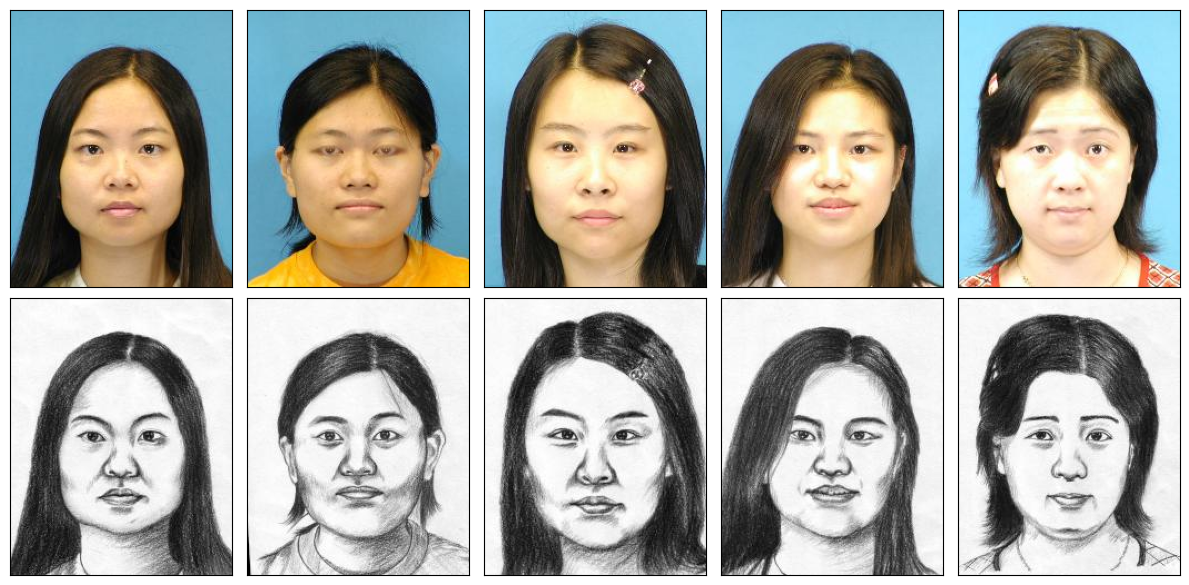

In [5]:
import os
from natsort import natsorted, ns
from PIL import Image
import matplotlib.pyplot as plt

# Define paths
portrait_path = r'/content/drive/MyDrive/kaggle_datasets/photos'
sketches_path = r'/content/drive/MyDrive/kaggle_datasets/sketches'

# Get image names
portrait_imgname = os.listdir(portrait_path)
sketches_imgname = os.listdir(sketches_path)

# Sort image names
portrait_imgname = natsorted(portrait_imgname, alg=ns.IGNORECASE)
sketches_imgname = natsorted(sketches_imgname, alg=ns.IGNORECASE)

# Create full paths for images
portrait_imgs = [os.path.join(portrait_path, imgname) for imgname in portrait_imgname]
sketches_imgs = [os.path.join(sketches_path, imgname) for imgname in sketches_imgname]

# Number of images to display
imgnum = 5
imgrow = 2

# Display images
plt.figure(figsize=(12, 6))
for i in range(imgnum):
    # Open images
    with Image.open(portrait_imgs[i]) as image:
        with Image.open(sketches_imgs[i]) as image2:
            # Display portrait image
            plt.subplot(imgrow, imgnum, i+1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            # Display sketch image
            plt.subplot(imgrow, imgnum, i+imgnum+1)
            plt.imshow(image2, cmap="gray")
            plt.xticks([])
            plt.yticks([])

plt.tight_layout()
plt.show()


In [6]:
def load(image_path):
    image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(image_path), channels=IN_CHANNEL), tf.float32)
    return image

resize = lambda image, height, width: tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

def normalize(image):
    return tf.image.per_image_standardization(image)

#data augmentation
flip = lambda image: tf.image.flip_left_right(image)

adjustment_seed = 1
random.seed(adjustment_seed)

def random_adjustment(image1, image2):
    rand_bright = tf.random.uniform([], 1, 5)
    rand_contrast = tf.random.uniform([], 1, 2)

    image1 = tf.image.adjust_brightness(image1, delta=rand_bright)
    image2 = tf.image.adjust_brightness(image2, delta=rand_bright)

    image1 = tf.image.adjust_contrast(image1, contrast_factor=rand_contrast)
    image2 = tf.image.adjust_contrast(image2, contrast_factor=rand_contrast)

    image1 = tf.cast(image1, tf.float32)
    image2 = tf.cast(image2, tf.float32)

    return image1, image2


IMG_SIZE = 256
#the in channel and out channel has to be the same for tf batch
#even though the generated image is greyscale (1channel), it is converted into RGB (3channels)
IN_CHANNEL = 3
OUT_CHANNEL = IN_CHANNEL
TRAIN_BATCH = 4

In [7]:
tempsize = 4
imgs = []
imgs = [
    [normalize(resize(load(portrait_imgs[i]), IMG_SIZE, IMG_SIZE)),
     normalize(resize(load(sketches_imgs[i]), IMG_SIZE, IMG_SIZE))]
    for i in range(tempsize)
]

imgs = tf.convert_to_tensor(imgs)
print(imgs.shape)

(4, 2, 256, 256, 3)


images in trainset: 534
trainset len: 134


(4, 2, 256, 256, 3)


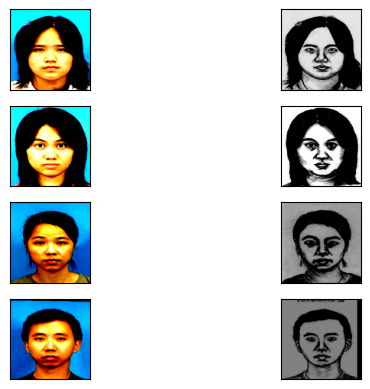

In [8]:
BUFFER_SIZE = len(portrait_imgs)
TRAIN_SIZE = int(BUFFER_SIZE*0.95)
TEST_SIZE =  int(BUFFER_SIZE - TRAIN_SIZE)

train_imgs_idx = []
test_imgs_idx = []

train_imgs = []
test_imgs = []

for i in range(BUFFER_SIZE):
        portrait_img = load(portrait_imgs[i])
        portrait_img = resize(portrait_img,IMG_SIZE,IMG_SIZE)

        sketch_img = load(sketches_imgs[i])
        sketch_img = resize(sketch_img,IMG_SIZE,IMG_SIZE)

        #data augmentation
        portrait_img2 = flip(portrait_img)
        portrait_img2 = normalize(portrait_img2)

        sketch_img2 = flip(sketch_img)
        sketch_img2 = normalize(sketch_img2)

        portrait_img3,sketch_img3 = random_adjustment(portrait_img,sketch_img)
        portrait_img3 = normalize(portrait_img3)
        sketch_img3 = normalize(sketch_img3)

        portrait_img = normalize(portrait_img)
        sketch_img = normalize(sketch_img)

        if (i<TRAIN_SIZE):
            train_imgs.append(tf.convert_to_tensor([portrait_img,sketch_img]))
            train_imgs.append(tf.convert_to_tensor([portrait_img2,sketch_img2]))
            train_imgs.append(tf.convert_to_tensor([portrait_img3,sketch_img3]))
        else:
            test_imgs.append(tf.convert_to_tensor([portrait_img,sketch_img]))
            test_imgs.append(tf.convert_to_tensor([portrait_img2,sketch_img2]))
            test_imgs.append(tf.convert_to_tensor([portrait_img3,sketch_img3]))


train_set = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(train_imgs))
print("images in trainset:",len(train_set))

train_set = train_set.shuffle(len(train_set))
for i,data in enumerate(train_set):
    if (i>=imgnum):
        break


train_set = train_set.batch(TRAIN_BATCH)
print("trainset len:",len(train_set))

for batch_items in train_set.repeat().take(1):
    print(batch_items.shape)
    temp_num_of_img_pair = len(batch_items)
    idx = 1
    for image_pair in batch_items:
        #print(image_pair.shape)
        input_image, target_image = image_pair

        ax = plt.subplot(temp_num_of_img_pair,2,idx)
        plt.imshow(input_image)
        plt.xticks([])
        plt.yticks([])
        idx+=1

        ax = plt.subplot(temp_num_of_img_pair,2,idx)
        plt.imshow(target_image, cmap="gray")
        plt.xticks([])
        plt.yticks([])
        idx+=1


test_set = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(test_imgs))
test_set = test_set.shuffle(len(test_set))

In [9]:
def downsample(feature, kernel, apply_batchnorm=False):
    layers = []
    layers.append(tf.keras.layers.Conv2D(feature, kernel, strides=2, padding='same', use_bias=not apply_batchnorm))
    if apply_batchnorm:
        layers.append(tf.keras.layers.BatchNormalization())
    layers.append(tf.keras.layers.LeakyReLU())
    return tf.keras.Sequential(layers)


def upsample(feature, kernel, apply_batchnorm=False, apply_dropout=False, dropout=0):
    layers = [
        tf.keras.layers.Conv2DTranspose(feature, kernel, strides=2, padding='same', use_bias=not apply_batchnorm)
    ]

    if apply_batchnorm:
        layers.append(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        layers.append(tf.keras.layers.Dropout(dropout))

    layers.append(tf.keras.layers.LeakyReLU())

    return tf.keras.Sequential(layers)


(1, 128, 128, 12)


(1, 256, 256, 3)


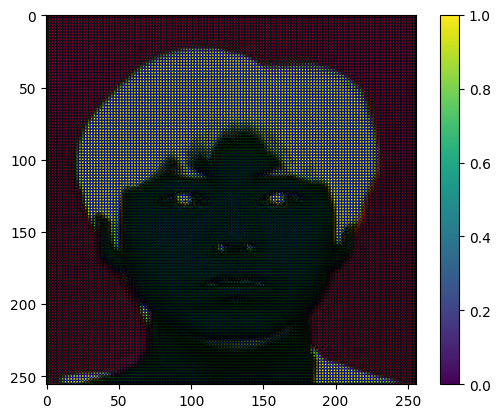

In [10]:
input_shape = (1, IMG_SIZE, IMG_SIZE, IN_CHANNEL) #1 represents batch size
x = tf.random.normal(input_shape)

inp = data[0]
x = inp[tf.newaxis, ...]
y = downsample(12,4)(x)
print(y.shape)

x_restored = upsample(OUT_CHANNEL,4)(y)
print(x_restored.shape)
plt.imshow(x_restored[0, ...])
plt.colorbar()

In [11]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, IN_CHANNEL])

    #the comment below is considering IMG_SIZE=256
    down_stack = [
        downsample(64, 4),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
    ]
    #the up_stack does not include the last layer of forming the desired image
    up_stack = [
        upsample(256, 4),  # (batch_size, 32, 32, 256)
        upsample(128, 4),  # (batch_size, 64, 64, 128)
        upsample(64, 4),  # (batch_size, 128, 128, 64)
    ]
    last = tf.keras.layers.Conv2DTranspose(OUT_CHANNEL, 4,
                                           strides=2,
                                           padding='same',
                                           activation='tanh')  # (batch_size, 256, 256, channel)
    x = inputs

    #downsampling
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    #upsampling (with skip connection)
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [14]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64,to_file='generator.png')
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_9 (Sequential)   (None, 128, 128, 64)         3136      ['input_2[0][0]']             
                                                                                                  
 sequential_10 (Sequential)  (None, 64, 64, 128)          131200    ['sequential_9[0][0]']        
                                                                                                  
 sequential_11 (Sequential)  (None, 32, 32, 256)          524544    ['sequential_10[0][0]']       
                                                                                            

([], [])

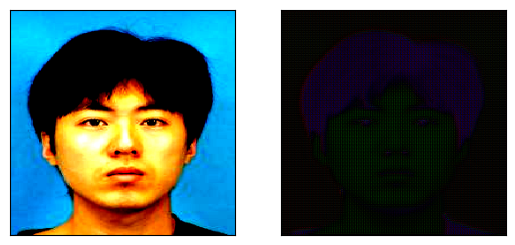

In [15]:
inp = data[0]
gen_output = generator(inp[tf.newaxis, ...], training=False)
ax = plt.subplot(1,2,1)
plt.imshow(inp)
plt.xticks([])
plt.yticks([])
ax = plt.subplot(1,2,2)
plt.imshow(gen_output[0, ...])
plt.xticks([])
plt.yticks([])

In [16]:
LAMBDA = 100

In [17]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [19]:
def Discriminator():
    inp = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, IN_CHANNEL], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUT_CHANNEL], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, total channels)

    #get the features from the image
    x = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    x = downsample(128, 4)(x)  # (batch_size, 64, 64, 128)
    x = downsample(256, 4)(x)  # (batch_size, 32, 32, 256)

    #make the output image NxN with 1 channel
    x = tf.keras.layers.Conv2D(1, 1, strides=1, padding='valid')(x)  # (batch_size, size, size, 1)
    return tf.keras.Model(inputs=[inp, tar], outputs=x)

In [20]:
input_shape = (1, 32, 32, 256) #1 represents batch size
x = tf.random.normal(input_shape)
print(x.shape)

y = tf.keras.layers.Conv2D(1, 1, strides=1, padding='valid')(x)
print(y.shape)

(1, 32, 32, 256)
(1, 32, 32, 1)


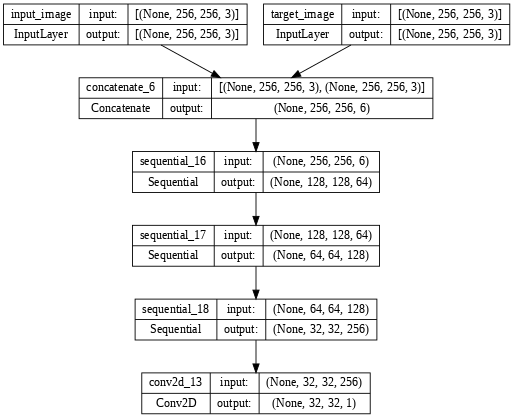

In [21]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64,to_file='discriminator.png')

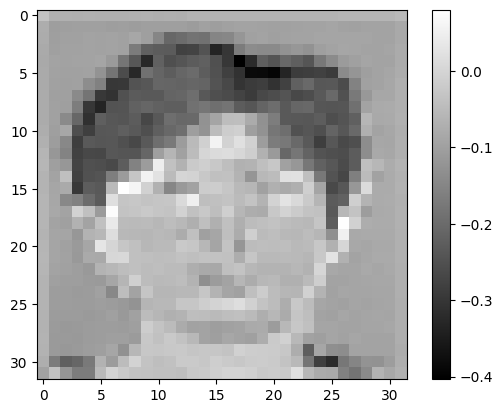

In [22]:
inp = data[0]
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ...], cmap="gray")
plt.colorbar()

In [23]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [24]:
generator_optimizer = tf.keras.optimizers.Adam()#(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam()#(2e-4, beta_1=0.5)

In [25]:
@tf.function
def train_step(input_images,target_images,epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        #TRAIN THE GENERATOR

        #generates image
        gen_output = generator(input_images, training=True)
        #get the disriminator output of generated image
        disc_gen_output = discriminator([input_images,gen_output], training=True)
        #get the loss function
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_gen_output, gen_output, target_images)
        #apply gradient
        generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))

        #TRAIN THE DISCRIMINATOR

        #get the discriminator output of real image
        disc_real_output = discriminator([input_images,target_images], training=True)
        #get the loss function
        disc_loss = discriminator_loss(disc_real_output, disc_gen_output)
        #apply gradient
        discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

    return gen_total_loss,disc_loss

In [26]:
gen_losses = []
disc_losses = []

def train(train_dataset, epochs=56):
    for epoch in range(epochs):
        start = time.time()
        for batch in train_dataset:
            input_images = []
            target_images = []

            for image_pair in batch:
                input_image = image_pair[0]
                target_image = image_pair[1]

                input_images.append(input_image)
                target_images.append(target_image)

            input_images = tf.convert_to_tensor(input_images)
            target_images = tf.convert_to_tensor(target_images)

            gen_loss, disc_loss = train_step(input_images, target_images, epoch)
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        if epoch % 5 == 0:
            print("epoch {} gen loss:{}, disc loss:{}".format(epoch, gen_loss, disc_loss))
            print("time taken for 5 epoch:{}s".format(time.time() - start))
            start = time.time()

    return gen_losses, disc_losses

gen_losses, disc_losses = train(train_set)


epoch 0 gen loss:38.867557525634766, disc loss:1.06480073928833
time taken for 5 epoch:20.079020261764526s
epoch 5 gen loss:36.309024810791016, disc loss:0.8004142045974731
time taken for 5 epoch:10.916062355041504s
epoch 10 gen loss:37.28985595703125, disc loss:0.8622260689735413
time taken for 5 epoch:10.874395847320557s
epoch 15 gen loss:35.77268600463867, disc loss:0.8063270449638367
time taken for 5 epoch:10.829942226409912s
epoch 20 gen loss:30.275781631469727, disc loss:0.8273618817329407
time taken for 5 epoch:10.87848711013794s
epoch 25 gen loss:29.485061645507812, disc loss:0.8294743299484253
time taken for 5 epoch:10.973423480987549s
epoch 30 gen loss:29.275226593017578, disc loss:0.8124860525131226
time taken for 5 epoch:10.904465675354004s
epoch 35 gen loss:33.86046600341797, disc loss:0.8360486030578613
time taken for 5 epoch:20.46404719352722s
epoch 40 gen loss:29.26414680480957, disc loss:0.788740873336792
time taken for 5 epoch:10.90235161781311s
epoch 45 gen loss:26.6

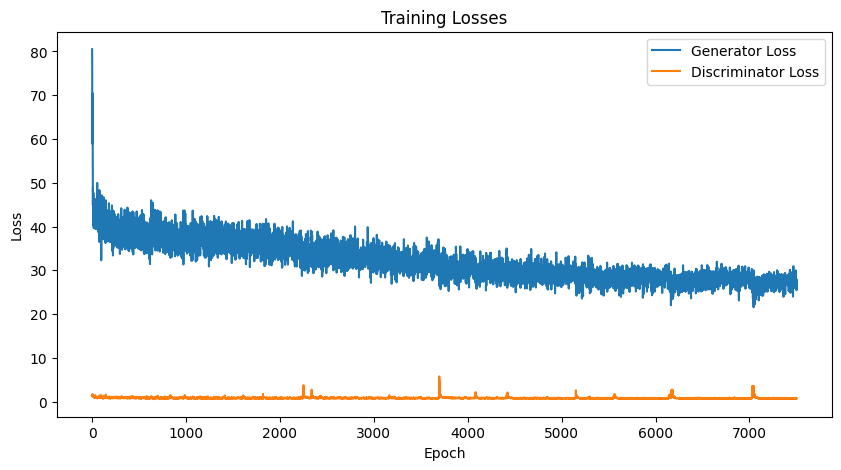

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()


With checkpoints, early stopping, dropout

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

def train(train_dataset, epochs=56):
    generator_optimizer = Adam()
    discriminator_optimizer = Adam()

    checkpoint_path = "training_checkpoints/"
    checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                 save_weights_only=True,
                                 save_best_only=True,
                                 monitor='gen_loss',
                                 mode='min',
                                 verbose=1)

    early_stopping = EarlyStopping(monitor='gen_loss',
                                   patience=10,
                                   mode='min',
                                   verbose=1,
                                   restore_best_weights=True)

    for epoch in range(epochs):
        start = time.time()
        gen_losses = []
        disc_losses = []

        for batch in train_dataset:
            input_images = []
            target_images = []

            for image_pair in batch:
                input_image = image_pair[0]
                target_image = image_pair[1]

                input_images.append(input_image)
                target_images.append(target_image)

            input_images = tf.convert_to_tensor(input_images)
            target_images = tf.convert_to_tensor(target_images)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                gen_loss, disc_loss = train_step(input_images, target_images, epoch)
                gen_losses.append(gen_loss)
                disc_losses.append(disc_loss)

            generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

        gen_loss = np.mean(gen_losses)
        disc_loss = np.mean(disc_losses)

        if epoch % 5 == 0:
            print("epoch {} gen loss:{}, disc loss:{}".format(epoch, gen_loss, disc_loss))
            print("time taken for 5 epoch:{}s".format(time.time() - start))
            start = time.time()

    return gen_losses, disc_losses

gen_losses, disc_losses = train(train_set)

epoch 0 gen loss:98.98464965820312, disc loss:0.37169456481933594
time taken for 5 epoch:27.939969539642334s
epoch 5 gen loss:144.80926513671875, disc loss:7.647068559890613e-05
time taken for 5 epoch:25.353472471237183s
epoch 10 gen loss:139.0810546875, disc loss:0.00010363348701503128
time taken for 5 epoch:25.687808990478516s
epoch 15 gen loss:132.4664764404297, disc loss:8.0222935139318e-06
time taken for 5 epoch:25.500362396240234s
epoch 20 gen loss:133.7525634765625, disc loss:3.700009528984083e-06
time taken for 5 epoch:26.35219383239746s
epoch 25 gen loss:136.6490478515625, disc loss:9.922336175804958e-06
time taken for 5 epoch:25.451501846313477s
epoch 30 gen loss:139.369140625, disc loss:3.3120502394012874e-06
time taken for 5 epoch:25.280359983444214s
epoch 35 gen loss:142.40464782714844, disc loss:2.044199618467246e-06
time taken for 5 epoch:26.288318157196045s
epoch 40 gen loss:140.0113067626953, disc loss:1.8102250578522217e-06
time taken for 5 epoch:25.03949499130249s
ep

Hyperparameter tuning

In [32]:
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3]
batch_size = [8, 32, 64]
epochs = [10, 50, 100]

results = []

def train(train_dataset, epochs=56):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        start = time.time()
        for batch in train_dataset:
            input_images = []
            target_images = []

            for image_pair in batch:
                input_image = image_pair[0]
                target_image = image_pair[1]

                input_images.append(input_image)
                target_images.append(target_image)

            input_images = tf.convert_to_tensor(input_images)
            target_images = tf.convert_to_tensor(target_images)

            gen_loss, disc_loss = train_step(input_images, target_images, epoch)
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        if epoch % 5 == 0:
            print("epoch {} gen loss:{}, disc loss:{}".format(epoch, gen_loss, disc_loss))
            print("time taken for 5 epoch:{}s".format(time.time() - start))
            start = time.time()

    return gen_losses, disc_losses

results = []

for lr in learning_rates:
    for bs in batch_size:
        for ep in epochs:
            generator_optimizer = tf.keras.optimizers.Adam(lr)
            discriminator_optimizer = tf.keras.optimizers.Adam(lr)

            gen_losses, disc_losses = train(train_set, epochs=ep)
            results.append((lr, bs, ep, gen_losses, disc_losses))

for lr, bs, ep, gen_losses, disc_losses in results:
    print(f"Learning Rate: {lr}, Batch Size: {bs}, Epochs: {ep}")
    print(f"Final Generator Loss: {gen_losses[-1]}, Final Discriminator Loss: {disc_losses[-1]}")


epoch 0 gen loss:144.09872436523438, disc loss:2.5358334099223612e-08
time taken for 5 epoch:8.337278127670288s
epoch 5 gen loss:143.10882568359375, disc loss:2.2121863452184698e-08
time taken for 5 epoch:8.651227474212646s
epoch 0 gen loss:143.98463439941406, disc loss:1.8782902344582908e-08
time taken for 5 epoch:8.60407280921936s
epoch 5 gen loss:148.69007873535156, disc loss:1.1048278736325301e-07
time taken for 5 epoch:10.222917318344116s
epoch 10 gen loss:147.6066436767578, disc loss:2.4911330775978513e-09
time taken for 5 epoch:8.602484226226807s
epoch 15 gen loss:144.5711669921875, disc loss:6.68645228074638e-08
time taken for 5 epoch:8.50783109664917s
epoch 20 gen loss:144.4091796875, disc loss:3.530626315750851e-07
time taken for 5 epoch:8.620504379272461s
epoch 25 gen loss:141.88467407226562, disc loss:1.191465202055042e-07
time taken for 5 epoch:8.47639513015747s
epoch 30 gen loss:142.6895751953125, disc loss:5.384892887150272e-08
time taken for 5 epoch:8.614133596420288s
e

ValueError: in user code:

    File "<ipython-input-25-c4a7ddce91c5>", line 15, in train_step  *
        generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients  **
        return super().apply_gradients(grads_and_vars, name=name)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 638, in apply_gradients
        self.build(trainable_variables)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/adam.py", line 145, in build
        self.add_variable_from_reference(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1125, in add_variable_from_reference
        return super().add_variable_from_reference(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 513, in add_variable_from_reference
        variable = tf.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


In [67]:
def denormalize(image):
  image = (image+1)
  image = image*127.5
  return image

30


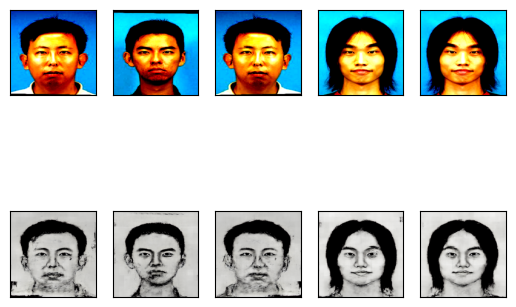

In [68]:
print(len(test_set))
temp_img_num = int(len(test_set)/2)
temp_img_num = 5

test_set1 = test_set.take(temp_img_num)
test_set2 = test_set.take(temp_img_num)

for step, (input_image, target_image) in test_set1.enumerate():
    ax = plt.subplot(2,temp_img_num,int(step)+1)
    plt.imshow(input_image)
    plt.xticks([])
    plt.yticks([])

    gen_output = generator(input_image[tf.newaxis, ...], training=False)
    ax = plt.subplot(2,temp_img_num,temp_img_num+int(step)+1)

    gen_output = gen_output[0,...]
    denorm_output = denormalize(gen_output)
    denorm_output = tf.cast(denorm_output,tf.int32)
    denorm_output = tf.clip_by_value(denorm_output,0,255)

    plt.imshow(denorm_output)
    plt.xticks([])
    plt.yticks([])

In [73]:
import tensorflow as tf
import numpy as np
from skimage.metrics import structural_similarity as ssim

def psnr(img1, img2):
    return tf.image.psnr(img1, img2, max_val=255)

def ssim_metric(img1, img2):
    img1 = tf.cast(img1, tf.float32)
    img2 = tf.cast(img2, tf.float32)
    return ssim(img1.numpy(), img2.numpy(), data_range=255, multichannel=True)

psnr_values = []
ssim_values = []

for input_image, target_image in test_set2:
    gen_output = generator(input_image[tf.newaxis, ...], training=False)
    gen_output = gen_output[0, ...]

    psnr_value = psnr(target_image, gen_output)
    ssim_value = ssim_metric(target_image.numpy(), gen_output.numpy())

    psnr_values.append(psnr_value)
    ssim_values.append(ssim_value)

print("Average PSNR:", np.mean(psnr_values))
print("Average SSIM:", np.mean(ssim_values))


Average PSNR: 51.23053
Average SSIM: 0.97215205


<ipython-input-73-a0ae18d2efad>:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(img1.numpy(), img2.numpy(), data_range=255, multichannel=True)
